# Inference Cache Comparator

Simple helper to inspect and compare inference cache entries (`results/inference_cache`).

You can set two cache entries (method, dataset tag, config hash) and plot/compute basic differences.


=== Entry A ===
method: cascade
dataset: jGCaMP8f_ANM471993_cell01_test_new_s30Hz_rs30
cache_key: fc514770508881bb
sampling_rate: 30.006769820043054
time_stamps shape: (2465,)
spike_prob shape: (2465,)
reconstruction shape: None
discrete_spikes shape: (2465,)

=== Entry B ===
method: cascade
dataset: jGCaMP8f_ANM471993_cell01_test_legacy_s30Hz_rs30
cache_key: fc514770508881bb
sampling_rate: 30.006769820043054
time_stamps shape: (2465,)
spike_prob shape: (2465,)
reconstruction shape: None
discrete_spikes shape: (2465,)

max |spike_prob diff|: 0.0
max |discrete diff|: 1.0


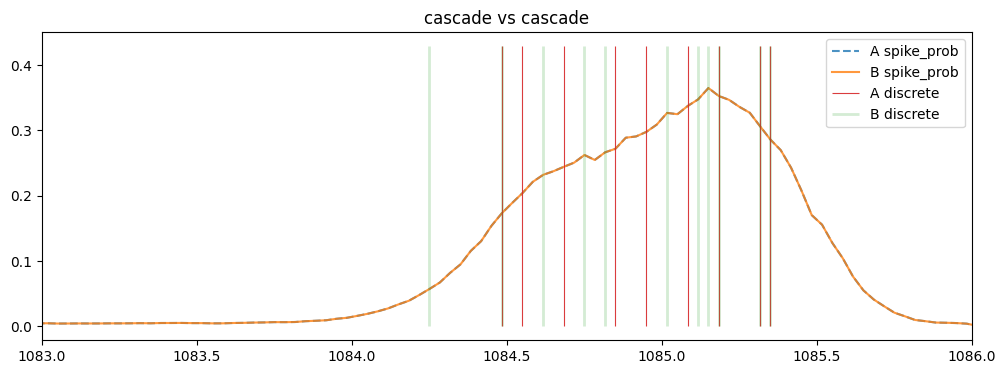

In [10]:
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt

# Root of the cache (relative to repo)
CACHE_ROOT = Path("results") / "inference_cache"

def load_cache_entry(method: str, dataset_tag: str, config_hash: str):
    mat_path = CACHE_ROOT / method / dataset_tag / f"{config_hash}.mat"
    meta_path = CACHE_ROOT / method / dataset_tag / f"{config_hash}.json"
    if not mat_path.exists() or not meta_path.exists():
        raise FileNotFoundError(f"Missing cache files: {mat_path}, {meta_path}")
    import scipy.io as sio
    data = sio.loadmat(mat_path)
    with meta_path.open("r", encoding="utf-8") as fh:
        meta = json.load(fh)
    time_stamps = np.asarray(data.get("time_stamps")).squeeze()
    spike_prob = np.asarray(data.get("spike_prob")).squeeze()
    reconstruction = data.get("reconstruction")
    reconstruction = None if reconstruction is None else np.asarray(reconstruction).squeeze()
    discrete = data.get("discrete_spikes")
    discrete = None if discrete is None else np.asarray(discrete).squeeze()
    return {
        "time_stamps": time_stamps,
        "spike_prob": spike_prob,
        "reconstruction": reconstruction,
        "discrete_spikes": discrete,
        "meta": meta,
    }

def describe(entry):
    print("method:", entry["meta"].get("method"))
    print("dataset:", entry["meta"].get("dataset"))
    print("cache_key:", entry["meta"].get("cache_key"))
    print("sampling_rate:", entry["meta"].get("sampling_rate"))
    print("time_stamps shape:", entry["time_stamps"].shape)
    print("spike_prob shape:", entry["spike_prob"].shape)
    print("reconstruction shape:", None if entry["reconstruction"] is None else entry["reconstruction"].shape)
    print("discrete_spikes shape:", None if entry["discrete_spikes"] is None else entry["discrete_spikes"].shape)

def plot_overlay(a, b, title="Overlay", xlim=None):
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(a["time_stamps"], a["spike_prob"], label="A spike_prob", alpha=0.8,linestyle='--')
    ax.plot(b["time_stamps"], b["spike_prob"], label="B spike_prob", alpha=0.8)

    # Overlay discrete spikes as vertical lines if present
    if a.get("discrete_spikes") is not None and a["discrete_spikes"].size == a["time_stamps"].size:
        mask_a = a["discrete_spikes"] > 0
        if np.any(mask_a):
            ax.vlines(
                a["time_stamps"][mask_a],
                ymin=np.nanmin(a["spike_prob"]),
                ymax=np.nanmax(a["spike_prob"]),
                color="tab:red",
                alpha=0.9,
                linewidth=0.8,
                label="A discrete",
            )
    if b.get("discrete_spikes") is not None and b["discrete_spikes"].size == b["time_stamps"].size:
        mask_b = b["discrete_spikes"] > 0
        if np.any(mask_b):
            ax.vlines(
                b["time_stamps"][mask_b],
                ymin=np.nanmin(b["spike_prob"]),
                ymax=np.nanmax(b["spike_prob"]),
                color="tab:green",
                alpha=0.2,
                linewidth=2,
                label="B discrete",
            )

    ax.set_title(title)
    ax.legend()
    if xlim:
        ax.set_xlim(*xlim)
    plt.show()

def max_abs_diff(a, b):
    if a.shape != b.shape:
        return None
    mask = np.isfinite(a) & np.isfinite(b)
    if not mask.any():
        return None
    return float(np.max(np.abs(a[mask] - b[mask])))

# Example inputs: set these to the cache entries you want to compare
method_a = "cascade"
dataset_a = "jGCaMP8f_ANM471993_cell01_test_new_s30Hz_rs30"
hash_a = "fc514770508881bb"  # config hash (json/mat basename)

method_b = "cascade"
dataset_b = "jGCaMP8f_ANM471993_cell01_test_legacy_s30Hz_rs30"
hash_b = "fc514770508881bb"  # adjust as needed

# Load entries
entry_a = load_cache_entry(method_a, dataset_a, hash_a)
entry_b = load_cache_entry(method_b, dataset_b, hash_b)

print("=== Entry A ===")
describe(entry_a)
print("\n=== Entry B ===")
describe(entry_b)

# Compute simple diffs (only if shapes match)
print("\nmax |spike_prob diff|:", max_abs_diff(entry_a["spike_prob"], entry_b["spike_prob"]))
if entry_a["discrete_spikes"] is not None and entry_b["discrete_spikes"] is not None:
    print("max |discrete diff|:", max_abs_diff(entry_a["discrete_spikes"], entry_b["discrete_spikes"]))

# Quick overlay plot
plot_overlay(entry_a, entry_b, title=f"{method_a} vs {method_b}",xlim=[1083,1086])
